In [13]:
! pip3 install evaluate
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk(".") if "dsait4090_project_location" in files), "."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Colab: /content/drive/Othercomputers/macbook_pro/fact-checking


In [14]:
%load_ext autoreload
%autoreload

import logging
import torch
from torch import nn
from time import time

from src.models.deberta_v3 import DEBERTA_V3_CONFIG
from src.models.numt5 import NUM_T5_CONFIG
from src.models.elastic_roberta import ELASTIC_ROBERTA_CONFIG
from src.models.bart_large_mnli import BART_LARGE_MNLI_CONFIG
from src.models.gpt2 import GPT2_CONFIG
from src.models.roberta_large_mnli import ROBERTA_LARGE_MNLI_CONFIG
from src.common import DATA_PATH, read_data, get_device, DOC, NO_DECOMPOSITION, GPT3_5_TURBO, FLANT5
from src.classification_training import ClassificationTraining
from src.quantemp_processor import QuantempProcessor

logging.basicConfig(level=logging.ERROR)

device = get_device()

def data_path(decomposition: str, split: str):
    if decomposition == 'doc':
        path = f'raw_data/{split}_claims.json'
    elif decomposition == 'no_decomposition':
        return f'no_decomposition/{split}_evidences_no_decomposition.json'
    else:
        path = f'{decomposition}/{split}_evidences_decomposed_{decomposition}.json'

    return os.path.join(DATA_PATH, path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA: 1, use NVIDIA A100-SXM4-40GB


In [18]:
%autoreload

config = [
    (NUM_T5_CONFIG, NO_DECOMPOSITION),
    (NUM_T5_CONFIG, GPT3_5_TURBO),
    (NUM_T5_CONFIG, FLANT5),
]

print(len(config))
for model, decomposition in config:
    print(f'{model["name"]} - {decomposition}')

3
numt5 - no_decomposition
numt5 - gpt3.5-turbo
numt5 - flant5


In [ ]:
%autoreload

DATA_LIMIT = None

for i, (model_config, decomposition) in enumerate(config):
    t0 = time()
    model_name = model_config['name']
    model_type = model_config['model']
    tokenizer_type = model_config['tokenizer']

    print(f"{'='*60}\n({i+1} / {len(config)})  {model_name.upper()} | {decomposition.upper()}   \n{'='*60}")

    train_claims = read_data(data_path(decomposition, 'train'))[:DATA_LIMIT]
    val_claims = read_data(data_path(decomposition, 'val'))[:DATA_LIMIT]
    test_claims = read_data(data_path(decomposition, 'test'))[:DATA_LIMIT]

    tokenizer = tokenizer_type()
    data_processor = QuantempProcessor(tokenizer, decomposition=decomposition)
    train_dataset = data_processor.transform(train_claims)
    val_dataset = data_processor.transform(val_claims)
    test_dataset = data_processor.transform(test_claims)

    model = model_type(tokenizer=tokenizer).to(device)

    training = ClassificationTraining(
        model_name=f"{model_name}_{decomposition}",
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        model=model,
        optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8),
        loss_function=nn.CrossEntropyLoss(),
        batch_size=16,
        device=device,
        random_state=42
    )

    training.start_new_training()
    training.train(epochs=20, patience=2)
    training.evaluate_best_model(test_claims, test_dataset)

    t1 = time()
    print(f"Time: {(t1 - t0) / 60:.2f} min")



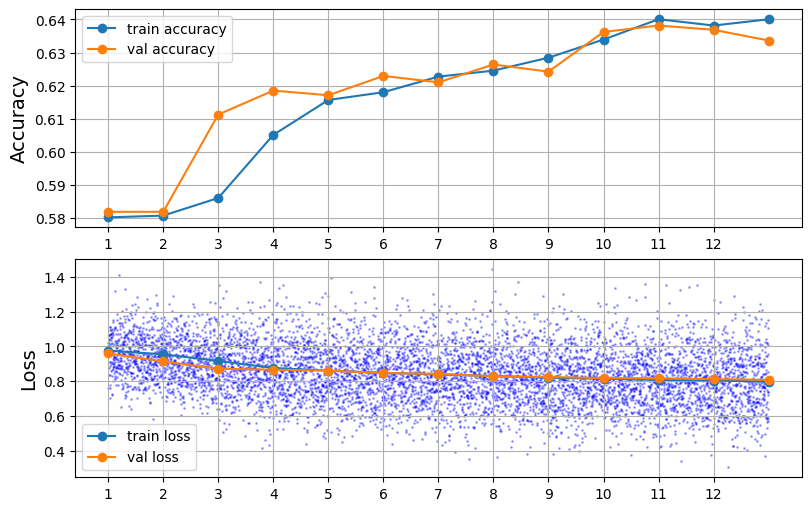

Loading model: best_model_11


  0%|          | 0/39 [00:00<?, ?it/s]

Saved to output/numt5_flant5


In [ ]:
%autoreload
training.plot_stats()
training.evaluate_best_model(test_claims, test_dataset)